In [1]:
## import modules

import fitbit 
import gather_keys_oauth2 as Oauth2
import pandas as pd
import numpy as np
import os
import csv 
from datetime import datetime, timedelta, date
from calandar_func import *
from query_build import *

In [2]:
## import db modules

import sqlalchemy as db
from sqlalchemy_utils import database_exists, create_database
import psycopg2

/Users/Spencer/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


##### Defining Schema in SQL Alchemy Core

https://github.com/overiq/sqlalchemy/blob/master/03-Defining%20Schema%20in%20SQLAlchemy%20Core.ipynb

In [3]:
## check for db, if not create db

url = 'postgresql://@localhost/step_project' # create string path

engine = db.create_engine(url) 

## verify if db(url) exists... if not create. 
if not database_exists(engine.url):
    create_database(engine.url)
    connection = engine.connect()

print(database_exists(engine.url),', database exists --',url) # if True, DB exists

True , database exists -- postgresql://@localhost/step_project


### Verify table > step_tracker

In [5]:
## import db modules to create table parameters and dtypes

from sqlalchemy import create_engine, MetaData, Table, Integer, String, \
Numeric, Column, DateTime, CheckConstraint # look up CheckConstraint?

In [6]:
## verifiy step_tracker in [table names]

if not 'step_tracker' in engine.table_names():
    
    print('table: <step_tracker> created.')

    metadata = MetaData()  # metadata is a 'catalogue object' that stores info about the db including tables

    stepping_table = Table('step_tracker', metadata,
                           Column('date', String()),
                           Column('time', String()), #DateTime(timezone=False)),
                           Column('steps', Integer()),
                           Column('running_sum', Integer())
                          )

    metadata.create_all(engine)
    
else:
    print('Table -- step_tracker -- exists.')

Table -- step_tracker -- exists.


In [7]:
""" define functions """

def dateRange(start_date, end_date):
    """create two np.1d arrays"""
    
    today_rng = pd.date_range(start_date, end_date)
    yesterday_rng = today_rng[:-1]
    yesterday_rng = np.insert(yesterday_rng,0, yesterday_rng[0] - timedelta(days=1))
    
    return today_rng, yesterday_rng

""" define functions"""
def loadkeys(filename):
    """"
    load keys/tokens from CSV file with form;
    consumer_key, consumer_secret, access_token, access_token_secret
    """
    with open(filename) as f:
        items = f.readline().strip().split(' ')
        return items

""" Authorization of account and access + refresh tokens """

k = loadkeys("fitbit_keys.csv")
USER_ID, CLIENT_SECRET, user, password = str(k[0].split(',')[0]), \
                                str(k[0].split(',')[1]), \
                                str(k[0].split(',')[2]), \
                                str(k[0].split(',')[3])
    
server = Oauth2.OAuth2Server(USER_ID, CLIENT_SECRET)
server.browser_authorize()
 
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(USER_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

[29/Jul/2019:21:33:52] ENGINE Listening for SIGTERM.
[29/Jul/2019:21:33:52] ENGINE Listening for SIGHUP.
[29/Jul/2019:21:33:52] ENGINE Listening for SIGUSR1.
[29/Jul/2019:21:33:52] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[29/Jul/2019:21:33:52] ENGINE Started monitor thread 'Autoreloader'.
[29/Jul/2019:21:33:52] ENGINE Serving on http://127.0.0.1:8080
[29/Jul/2019:21:33:52] ENGINE Bus STARTED


127.0.0.1 - - [29/Jul/2019:21:34:36] "GET /?code=cb1fbbe8e406a6a7fa97e7c7fe144ba62b7674a6&state=2H9BGGUkFfM1iqP0y8dhJ5YE5zKTPD HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36"


[29/Jul/2019:21:34:37] ENGINE Bus STOPPING
[29/Jul/2019:21:34:42] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[29/Jul/2019:21:34:42] ENGINE Stopped thread 'Autoreloader'.
[29/Jul/2019:21:34:42] ENGINE Bus STOPPED
[29/Jul/2019:21:34:42] ENGINE Bus EXITING
[29/Jul/2019:21:34:42] ENGINE Bus EXITED
[29/Jul/2019:21:34:42] ENGINE Waiting for child threads to terminate...


In [8]:
## dates to call for data provided in external csv

d = loadkeys('dates_in_excel_sheet.csv')
start_date, end_date = str(d[0].split(',')[1]), \
                           str(d[0].split(',')[2])

## excecute func
today_rng, yesterday_rng = dateRange(start_date, end_date)

print('Searching for step data for the following dates ...')
print('\n')
print(str(today_rng))

Searching for step data for the following dates ...


DatetimeIndex(['2019-04-11', '2019-04-12', '2019-04-13', '2019-04-14',
               '2019-04-15', '2019-04-16', '2019-04-17', '2019-04-18',
               '2019-04-19', '2019-04-20', '2019-04-21', '2019-04-22',
               '2019-04-23', '2019-04-24', '2019-04-25', '2019-04-26',
               '2019-04-27', '2019-04-28', '2019-04-29', '2019-04-30'],
              dtype='datetime64[ns]', freq='D')


In [9]:
## For each day in trial date rng, verify whether data exists 

days_w_data = []

for today, yesterday in zip(today_rng, yesterday_rng): 
    
    #Steps initialization
    steps_stats2 = auth2_client.intraday_time_series('activities/steps', base_date=today, detail_level='1min')
    time_list = []
    steps_list = []

    #Steps Extraction
    for i in steps_stats2['activities-steps-intraday']['dataset']:
        steps_list.append(i['value'])
        time_list.append(i['time'])
        
    # create df from api call
    steps_df = pd.DataFrame({'date': today, # chooseing to not parse date & time
                             'time': time_list,
                             'steps':steps_list,
                            })
    
    # device not worn (i.e. no steps taken)
    no_steps_taken = 0
    if steps_df['steps'].sum() == no_steps_taken:
        print('No step data -- %s')
        continue
    elif steps_df['steps'].sum() > no_steps_taken:
        days_w_data.append(today.strftime('%Y-%m-%d'))
        
        
    
    # add new col
    steps_df['running_sum'] = steps_df['steps'].cumsum()
    
    # append df to db
    try: 
        stepping_table = steps_df.to_sql('step_tracker', engine, if_exists='append',
                                        dtype={'date': String(),
                                               'time': String(),
                                               'steps': Integer(),
                                               'running_sum': Integer()
                                        })
    # replace df    
    except: 
        stepping_table = steps_df.to_sql('step_tracker', engine, if_exists='replace',
                                        dtype={'date': String(),
                                               'time': String(),
                                               'steps': Integer(),
                                               'running_sum': Integer()
                                        })
    #except:
    #    print('no step data found for ')# + today) 
    
print('done.')

No step data -- %s
No step data -- %s
No step data -- %s
No step data -- %s
done.


In [10]:
### df manipultation - add/drop cols, set timeseries index

steps_df = pd.read_sql('step_tracker', engine)
time_idx = steps_df['time'].values[:1440]
drop_cols = ['date', 'time', 'index', 'date_time']

# combine date and time vars (string)... convert dtype to datetime
steps_df['date_time'] = pd.to_datetime(steps_df['date'] + ' ' + steps_df['time'])

# set index
steps_df.set_index(steps_df['date_time'], inplace=True)
steps_df = steps_df.drop(axis=1, columns = drop_cols)

print('done.')

done.


In [11]:
# add cols - month & weekday name

#steps_df['month'] = steps_df.index.month_name()
#steps_df['weekday_name'] = steps_df.index.weekday_name
#steps_df.head()

### 24 hrs [00:00:00 - 23:59:00]

In [70]:
# initialize iloc rng
start_iloc = 0
end_iloc = 1440

for date, count in zip(days_w_data, range(len(days_w_data))): 
    
    # create series based on iloc
    s = idx_locator(steps_df, date, start_iloc, end_iloc)
    
    # create new df with mean of days sampled
    try: 
        df_agg = verify_db_table(engine,s, date, count, df_agg=None)
    except:
        df_agg = verify_db_table(engine,s, date, count, df_agg)

## create cols mean_step_avg, cum_sum, and set time_idx    
try: 
    df_agg.drop(columns=['index'], axis=1, inplace=True) # if df_agg exists, drop indx col from read_sql func
except:
    print('no index col')
    
## pd query last 7 'active' days 

# initialize start-end points, select, assign cols to df
col_start = -abs(len(df_agg.columns) - 9)
df_agg = df_agg.iloc[:, col_start:]


[r, c] = df_agg.shape
df_agg['mean_step_total'] = (df_agg.sum(axis=1) / c).round(decimals=0)
df_agg['cumulative_sum'] = df_agg['mean_step_total'].cumsum()
df_agg['time_idx'] = time_idx
df_agg.set_index('time_idx', inplace=True, drop=True)


all_day_df = df_agg
del df_agg

print('done')

done


### Evening [6pm - midnight]

In [71]:
# initialize iloc rng
start_iloc = 1080
end_iloc = 1440

for date, count in zip(days_w_data, range(len(days_w_data))): 
    
    # create series based on iloc
    s = idx_locator(steps_df, date, start_iloc, end_iloc)
    
    # create new df with mean of days sampled
    try: 
        df_agg = verify_db_table(engine,s, date, count, df_agg=None)
    except:
        df_agg = verify_db_table(engine,s, date, count, df_agg)
        
### add up and average all columns at each row making new col

evening_idx = steps_df.index[start_iloc:end_iloc].strftime('%H:%M:%S')

try: 
    df_agg.drop(columns=['index'], axis=1, inplace=True) # if df_agg exists, drop indx col from read_sql func
except:
    print('no index col')
    
## pd query last 7 'active' days 

# initialize start-end points, select, assign cols to df
col_start = -abs(len(df_agg.columns) - 9)
df_agg = df_agg.iloc[:, col_start:]

[r, c] = df_agg.shape
df_agg['mean_step_total'] = (df_agg.sum(axis=1) / c).round(decimals=0)
df_agg['cumulative_sum'] = df_agg['mean_step_total'].cumsum()
df_agg['time_idx'] = evening_idx
df_agg.set_index('time_idx',inplace=True, drop=True)


        
evening_df = df_agg
del df_agg

print('done.')

done.


### Afternoon [noon-6pm]

In [73]:
# initialize iloc rng
start_iloc = 720
end_iloc = 1080

for date, count in zip(days_w_data, range(len(days_w_data))): 
    
    # create series based on iloc
    s = idx_locator(steps_df, date, start_iloc, end_iloc)
    
    # create new df with mean of days sampled
    try: 
        df_agg = verify_db_table(engine,s, date, count, df_agg=None)
    except:
        df_agg = verify_db_table(engine,s, date, count, df_agg)
        
### add up and average all columns at each row making new col

afternoon_idx = steps_df.index[start_iloc:end_iloc].strftime('%H:%M:%S')

try: 
    df_agg.drop(columns=['index'], axis=1, inplace=True) # if df_agg exists, drop indx col from read_sql func
except:
    print('no index col')
    
## pd query last 7 'active' days 

# initialize start-end points, select, assign cols to df
col_start = -abs(len(df_agg.columns) - 9)
df_agg = df_agg.iloc[:, col_start:]

[r, c] = df_agg.shape
df_agg['mean_step_total'] = (df_agg.sum(axis=1) / c).round(decimals=0)
df_agg['cumulative_sum'] = df_agg['mean_step_total'].cumsum()
df_agg['time_idx'] = afternoon_idx
df_agg.set_index('time_idx',inplace=True, drop=True)

        
afternoon_df = df_agg
del df_agg

print('done.')

done.


### Morning [6am - noon]

In [75]:
# initialize iloc rng
start_iloc = 360
end_iloc = 720

for date, count in zip(days_w_data, range(len(days_w_data))): 
    
    # create series based on iloc
    s = idx_locator(steps_df, date, start_iloc, end_iloc)
    
    # create new df with mean of days sampled
    try: 
        df_agg = verify_db_table(engine,s, date, count, df_agg=None)
    except:
        df_agg = verify_db_table(engine,s, date, count, df_agg)
        
### add up and average all columns at each row making new col

morning_idx = steps_df.index[start_iloc:end_iloc].strftime('%H:%M:%S')

try: 
    df_agg.drop(columns=['index'], axis=1, inplace=True) # if df_agg exists, drop indx col from read_sql func
except:
    print('no index col')
    
## pd query last 7 'active' days 

# initialize start-end points, select, assign cols to df
col_start = -abs(len(df_agg.columns) - 9)
df_agg = df_agg.iloc[:, col_start:]

[r, c] = df_agg.shape
df_agg['mean_step_total'] = (df_agg.sum(axis=1) / c).round(decimals=0)
df_agg['cumulative_sum'] = df_agg['mean_step_total'].cumsum()
df_agg['time_idx'] = morning_idx
df_agg.set_index('time_idx',inplace=True, drop=True)


        
morning_df = df_agg
del df_agg

print('done.')

done.


### Plots and Visualizations 

In [77]:
## subplot a total of 4 plots - 24 hrs, morning, afternoon, evening

In [78]:
## import modules

%matplotlib notebook 
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np

In [79]:
## initialize vars -- step goal, sub-goals (morn, after-, eve)

goal_setting = pd.read_csv('step_narr_parameters.csv').iloc[0]


def goals(goal_setting):
    main_goal, morn_goal, after_goal, eve_goal = [(np.repeat(goal_setting[3], len(time_idx))), # 24
                                                  (np.repeat(goal_setting[4], len(morning_idx))), # morn
                                                  (np.repeat(goal_setting[5], len(afternoon_idx))), # after
                                                  (np.repeat(goal_setting[6], len(evening_idx)))  # eve
                                                 ]
                                               
    return main_goal, morn_goal, after_goal, eve_goal # return goal values

# define 
main_goal, morn_goal, after_goal, eve_goal = goals(goal_setting)

In [81]:
## automate plt x & y_tick value assignment for each subplot

def y_tickMAX(morning_df, afternoon_df, evening_df, all_day_df):
    
    # define col_name
    yesterday_col = all_day_df.columns[-3]
    
    # yesterday -- define max y_tick values 
    y_morn_total = morning_df[yesterday_col].cumsum().iloc[-1]
    y_afternoon_total = afternoon_df[yesterday_col].cumsum().iloc[-1]
    y_eve_total = evening_df[yesterday_col].cumsum().iloc[-1]
    y_all_day_total = all_day_df[yesterday_col].cumsum().iloc[-1]
    
    return y_morn_total, y_afternoon_total, y_eve_total, y_all_day_total


y_morn_total, y_afternoon_total, y_eve_sum, y_all_day_total = y_tickMAX(morning_df, afternoon_df, evening_df, all_day_df)

In [82]:
## which max tick is larger -- 7 day average or day yesterday?

def largest_ytick(df, yesterday_total, goal): 
    
    seven_day_avg = df['cumulative_sum'].iloc[-1]
    goal = goal[1]
    scenerio1 = [seven_day_avg > yesterday_total, seven_day_avg > goal]
    scenerio2 = [seven_day_avg < yesterday_total, yesterday_total > goal]
    
    #if all([seven_day_avg > yesterday_total, seven_day_avg > goal]):
    if all(scenerio1):
        y_ticks = seven_day_avg
        print('seven_day', y_ticks)
        
    elif all(scenerio2):
        y_ticks = yesterday_total
        print('yesterday', y_ticks)
        
    else: #scenerio3
        y_ticks = goal
        print('goal', y_ticks)
    
    return y_ticks

allday_ytick, m_ytick, a_ytick, e_ytick = [largest_ytick(all_day_df, y_all_day_total, main_goal), # 24 hrs
                                           largest_ytick(morning_df, y_morn_total, morn_goal), #  morn
                                           largest_ytick(afternoon_df, y_afternoon_total, after_goal), # afternoon
                                           largest_ytick(evening_df, y_eve_sum, eve_goal)] # eve

seven_day 10748.0
seven_day 4126.0
seven_day 3432.0
goal 5000


In [83]:
# 24 hrs
xdtime_labels = ['$midnight$', '2:00 AM','4:00 AM', '6:00 AM', '8:00 AM', '10:00 AM', '$noon$', '2:00 PM', '4:00 PM',
                 '6:00 PM', '8:00 PM', '10:00 PM', '$midnight$']
# morning
xmtime_labels = ['6:00 AM','6:30 AM','7:00 AM','7:30 AM','8:00 AM','8:30 AM','9:00 AM','9:30 AM','10:00 AM','10:30 AM',
                 '11:00 AM','11:30 AM','$noon$']
# afternoon
xatime_labels = ['12:30 PM','12:30 PM','1:00 PM','1:30 PM','2:00 PM','2:30 PM','3:00 PM','3:30 PM','4:00 PM','4:30 PM',
                 '5:00 PM','5:30 PM','6:00 PM']

# evening
xetime_labels = ['6:00 PM','6:30 PM','7:00 PM','7:30 PM','8:00 PM','8:30 PM','9:00 PM','9:30 PM','10:00 PM','10:30 PM',
                 '11:00 PM','11:30 PM','$midnight$']

<IPython.core.display.Javascript object>


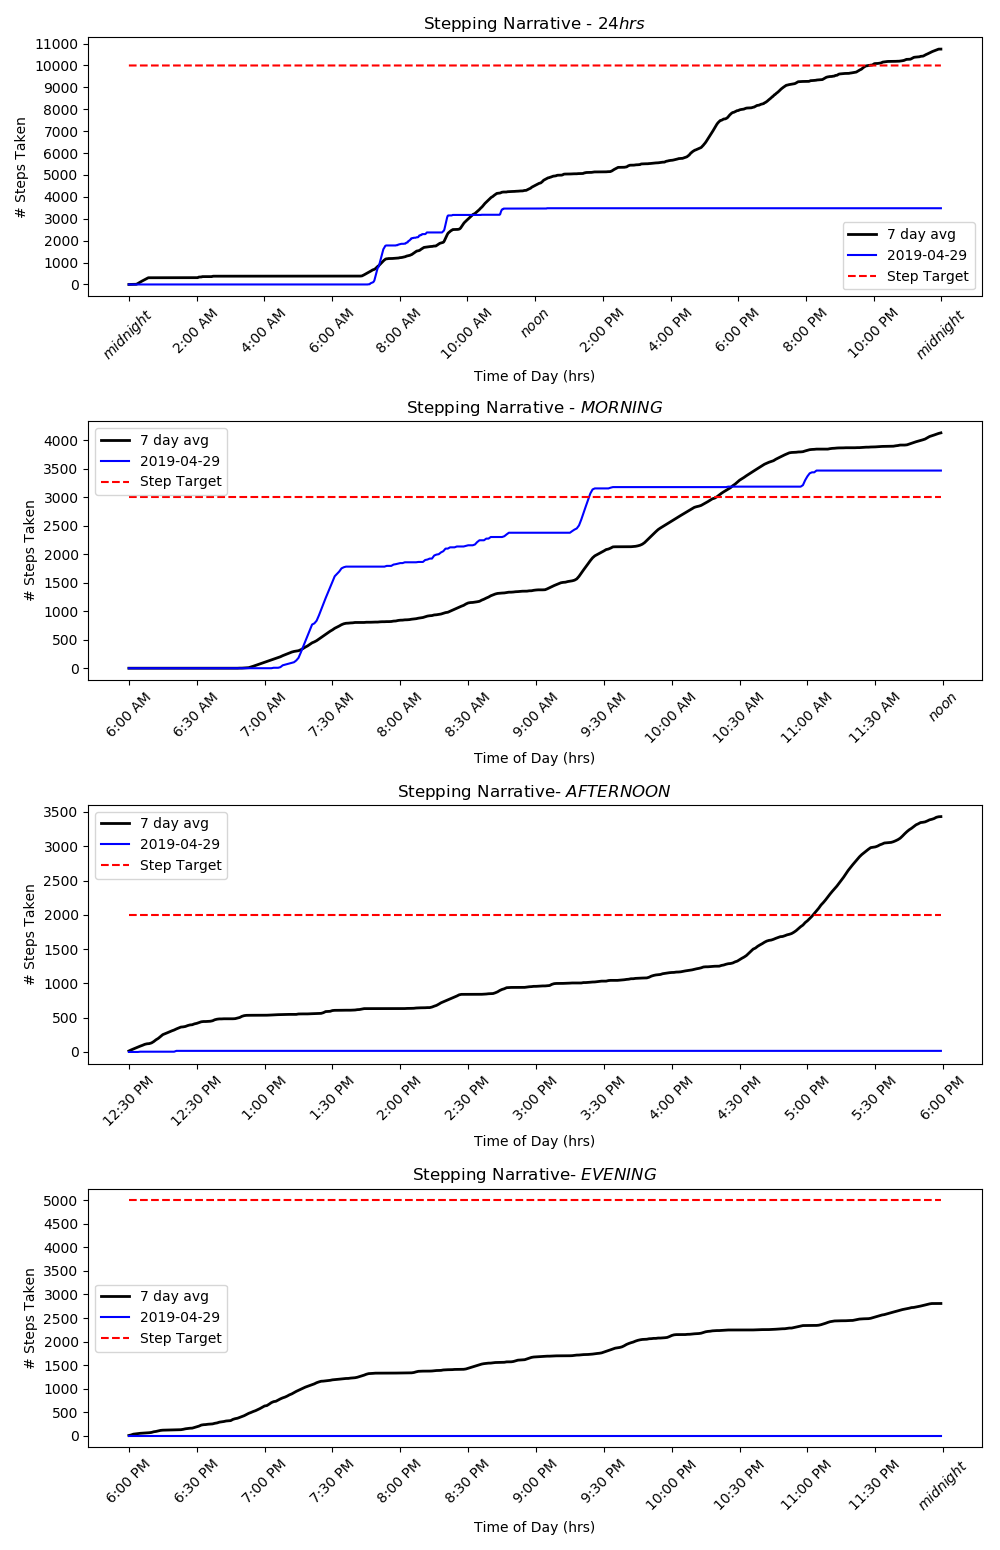

In [84]:
day = np.arange(0,1440+120,120)
morn = np.arange(0,360+60,30)

## create fig, subplots
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows=4, ncols=1, figsize=(10,15.5))

## set titles
ax1.set_title('Stepping Narrative - $24 hrs$')
ax2.set_title('Stepping Narrative - $MORNING$')
ax3.set_title('Stepping Narrative- $AFTERNOON$')
ax4.set_title('Stepping Narrative- $EVENING$')

## set labels

# 24 hrs
ax1.set_xlabel('Time of Day (hrs)')
ax1.set_ylabel('# Steps Taken')
# morning
ax2.set_xlabel('Time of Day (hrs)')
ax2.set_ylabel('# Steps Taken')
# afternoon
ax3.set_xlabel('Time of Day (hrs)')
ax3.set_ylabel('# Steps Taken')
# evening
ax4.set_xlabel('Time of Day (hrs)')
ax4.set_ylabel('# Steps Taken')


## xy_ticks, xy_labels

# 24 hrs
ax1.set_xticks(day)
ax1.set_xticklabels(xdtime_labels, rotation=45)
ax1.set_yticks(np.arange(0,allday_ytick+1000,1000))

# morning
ax2.set_xticks(morn) # *** change reflect same variable across subplots
ax2.set_xticklabels(xmtime_labels, rotation=45)
ax2.set_yticks(np.arange(0,m_ytick+500,500))
    
# afternoon
ax3.set_xticks(morn)
ax3.set_xticklabels(xatime_labels, rotation=45)
ax3.set_yticks(np.arange(0,a_ytick+500,500,))

# evening
ax4.set_xticks(morn)
ax4.set_xticklabels(xetime_labels,rotation=45)
ax4.set_yticks(np.arange(0,e_ytick+500,500))

## plt axes(1-4)
# 24 hrs
ax1.plot(all_day_df.index, all_day_df['cumulative_sum'],label='7 day avg',color='black', linewidth=2)
ax1.plot(all_day_df.index, all_day_df[all_day_df.columns[-3]].cumsum(),
         label=all_day_df.columns[-3], color='blue')
ax1.plot(all_day_df.index, main_goal,'--', label='Step Target', color='red')

# Morning
ax2.plot(morning_df.index, morning_df['cumulative_sum'],label='7 day avg', color='black', linewidth=2)
ax2.plot(morning_df.index, morning_df[morning_df.columns[-3]].cumsum(),
         label=morning_df.columns[-3], color='blue')
ax2.plot(morning_df.index, morn_goal,'--', label='Step Target', color='red')

# Afternoon
ax3.plot(afternoon_df.index, afternoon_df['cumulative_sum'], label='7 day avg', color='black', linewidth=2)
ax3.plot(afternoon_df.index, afternoon_df[afternoon_df.columns[-3]].cumsum(),
         label=afternoon_df.columns[-3], color='blue')
ax3.plot(afternoon_df.index, after_goal,'--', label='Step Target', color='red')

# Evening
ax4.plot(evening_df.index, evening_df['cumulative_sum'],label='7 day avg', color='black', linewidth=2)
ax4.plot(evening_df.index, evening_df[evening_df.columns[-3]].cumsum(),
         label=evening_df.columns[-3], color='blue')
ax4.plot(evening_df.index, eve_goal,'--', label='Step Target', color='red')

## set legend
ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
ax4.legend(loc='best')

# plt
fig.tight_layout()

# save subplots
file_path = os.path.join(os.path.abspath(''),'images.jpg')
fig.savefig(file_path)

In [ ]:
import smtplib
from email.message import EmailMessage
import imghdr
import config
import os

# Email Object
msg = EmailMessage()
msg['Subject'] = config.SUBJECT
msg['From'] = config.EMAIL_SENDER
msg['To'] = config.EMAIL_RECIPIENT
msg.set_content(config.CONTENT)

# Email Attachment
with open('images.jpg', 'rb') as f:
    file_data = f.read()
    file_type = imghdr.what(f.name)
    file_name = f.name

# Add attachement - jpg
msg.add_attachment(file_data, maintype='image', subtype=file_type, filename=file_name)

# Run SMTP protocol
with smtplib.SMTP('smtp.gmail.com:587') as server:
    server.ehlo()
    server.starttls()
    server.login(config.EMAIL_SENDER, config.PASSWORD)
    server.send_message(msg)
    server.quit()
